In [1]:
# standard imports
from typing import Union, Optional, List

# package imports
import pandas as pd
import numpy as np
import mobileclip
import open_clip
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

d:\Repos\clip-bold\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Dataset

In [2]:
class BOLDDataset(Dataset):
    def __init__(self, indices=None):
        self.indices = indices

        # path to mri data
        self.image_path = r"D:\Repos\clip-bold\data\intermediate\02_stimulus_step"
        # path to text data
        self.text_path = r"D:\Repos\clip-bold\data\intermediate\01_captions"
        # total image per (first 3) participants
        self.csi_size = 5254

        # preload captions
        self.captions = {}

        for i in range(4):
            with open(rf"D:\Repos\clip-bold\data\intermediate\01_captions\CSI{i+1}.txt") as file:
                captions = file.read().splitlines()
                self.captions[i+1] = captions

    def __len__(self):
        if self.indices is None:
            return 18870
        else:
            return len(self.indices)

    def __getitem__(self, idx):
        """
        Get mri image + caption text pair
        """
        try:
            i = self.indices[idx]
        except: 
            # some weird indexing issues on the last index
            i = self.indices[-1]

        # get participant index and offset
        participant = int(np.floor(i / self.csi_size) + 1)
        offset = i % self.csi_size

        # load image
        img_path = rf"D:\Repos\clip-bold\data\intermediate\02_stimulus_step\CSI{participant}-{offset}.npy"
        img = np.load(img_path).astype(np.float32).flatten()

        # load caption
        txt = self.captions[participant][offset]

        return img, txt

In [3]:
class BOLDDataModule(LightningDataModule):
    def __init__(self, train_frac, val_frac, test_frac, batch_size=32):
        super().__init__()

        self.batch_size = batch_size

        # initialise data
        self.dataset = BOLDDataset()
        # split data
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(self.dataset, [train_frac, val_frac, test_frac])

    def prepare_data(self):
        pass

    def train_dataloader(self):
        return DataLoader(BOLDDataset(self.train_dataset.indices), batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(BOLDDataset(self.val_dataset.indices), batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(BOLDDataset(self.test_dataset.indices), batch_size=self.batch_size)

# Model

In [4]:
class MRINetwork(LightningModule):
    """
    Base class for MobileCLIP with fMRI module
    """

    dtype = torch.float32

    def __init__(
        self,
        in_dim=150000,
        optimizer_lr=1e-5,
        optimizer_weight_decay=2e-2,
    ) -> None:

        # Model variables
        super().__init__()

        # Set optimizer learning rate and regularisation
        self.optimizer_lr = optimizer_lr
        self.optimizer_weight_decay = optimizer_weight_decay

        # load tokenizer 
        self.tokenizer = mobileclip.get_tokenizer('mobileclip_s2')
        self.tokenizer.eval()
        self.tokenizer.cuda()

        # load mobileclip
        self.model, _, _ = open_clip.create_model_and_transforms('MobileCLIP-S2', pretrained='datacompdr')

        # replace visual module with new component
        self.model.visual = nn.Sequential (
            nn.Linear(in_dim, 512, bias=True),
            nn.LayerNorm(512),
            nn.Mish(inplace=True),
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=512, nhead=8),
                num_layers=3,
                norm=nn.LayerNorm(512),
            )
        )

        # turn off gradients for text module
        for _, p in enumerate(self.model.text.parameters()):
            p.requires_grad_(False)

        self.model.cuda()

        # Save hyper-parameters in self.hparams
        self.save_hyperparameters()

    def forward(self, image, text):
        """
        Runs the forward propagation
        Parameters
        ----------
        X : torch.Tensor
            Input data with column features
        Returns
        -------
        torch.Tensor
            The network output
        """
        # compute normalised features
        image_features, text_features, logit_scale = self.model(image, self.tokenizer(text).cuda())

        # cosine similarity as logits
        logits_per_image = logit_scale * image_features @ text_features.T
        logits_per_text = logits_per_image.T

        return logits_per_image, logits_per_text
    
    def loss_function(self, logits_per_image, logits_per_text):
        """
        Compute contrastive loss
        """
        # contrastive loss
        labels = torch.arange(logits_per_image.shape[0], device='cuda')

        total_loss = (
            F.cross_entropy(logits_per_image, labels) +
            F.cross_entropy(logits_per_text, labels)
        ) / 2
        total_loss

        return total_loss

    def training_step(self, batch, batch_index):
        """
        A single training step used by pytorch_lightning.Trainer
        Parameters
        ----------
        batch : list
            First element contains the input tensor, second element contains the target output tensor.
        batch_index : int
            Step index in the current batch, which can be used for logging
        Returns
        -------
        torch.Tensor
            The loss value
        """
        self.model.train()

        image, text = batch

        # get logits
        logits_per_image, logits_per_text = self(image, text)

        # contrastive loss
        loss = self.loss_function(logits_per_image, logits_per_text)

        self.log("train_loss", loss, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_index):
        """
        A single validation step used by pytorch_lightning.Trainer
        Parameters
        ----------
        batch : list
            First element contains the input tensor, second element contains the target output tensor.
        batch_index : int
            Step index in the current batch, which can be used for logging
        Returns
        -------
        torch.Tensor
            The loss value
        """
        self.model.eval()

        # extract data from batch
        image, text = batch

        # get logits
        logits_per_image, logits_per_text = self(image, text)

        # contrastive loss
        loss = self.loss_function(logits_per_image, logits_per_text)

        self.log("val_loss", loss, prog_bar=True)

        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        self.model.eval()

        # extract data from batch
        image, text = batch

        # get logits
        logits_per_image, logits_per_text = self(image, text)

        return logits_per_image, logits_per_text

    def test_step(self, batch, batch_idx):
        self.model.eval()

        # extract data from batch
        image, text = batch

        # get logits
        logits_per_image, logits_per_text = self(image, text)

        # contrastive loss
        loss = self.loss_function(logits_per_image, logits_per_text)

        self.log("test_loss", loss, prog_bar=True)

        return loss

    def configure_optimizers(self):
        """
        Initialise the optimiser used by pytorch_lightning.Trainer()
        Returns
        -------
        torch.Optimizer
            An optimiser object for performing the backward step.
        """
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.optimizer_lr,
            weight_decay=self.optimizer_weight_decay,
        )
        return optimizer


# Trainer

In [5]:
def build_trainer(
    max_epochs: int,
    default_root_dir: str = r"D:\Repos\clip-bold\models\run0",
    enable_progress_bar: bool = True,
    enable_model_summary: bool = True,
    profiler: str = None,
    val_check_interval: Optional[Union[float, int]] = None,
    check_val_every_n_epoch: int = 1,
    accumulate_grad_batches: int = 1,
    callbacks: Optional[List] = None,
    early_stopping_patience: Optional[int] = None,
    logger=None,
):
    trainer_kwargs = {}

    # set root directory
    trainer_kwargs["default_root_dir"] = default_root_dir

    # set runtime
    trainer_kwargs["max_epochs"] = max_epochs

    # set gradient accumulation
    trainer_kwargs["accumulate_grad_batches"] = accumulate_grad_batches

    # set default callbacks
    if callbacks is None:
        trainer_kwargs["callbacks"] = []
    else:
        trainer_kwargs["callbacks"] = callbacks

    # set checkpointing
    trainer_kwargs["callbacks"].append(
        ModelCheckpoint(
            dirpath=default_root_dir,
            save_top_k=2,
            monitor="val_loss",
            mode="min",
            auto_insert_metric_name=True,
        ),
    )

    # set early stopping
    if early_stopping_patience is not None:
        trainer_kwargs["callbacks"].append(
            EarlyStopping(
                monitor="val_loss",
                mode="min",
                patience=early_stopping_patience,
                verbose=False,
            )
        )

    # set loggers
    trainer_kwargs["enable_progress_bar"] = enable_progress_bar
    trainer_kwargs["enable_model_summary"] = enable_model_summary
    trainer_kwargs["profiler"] = profiler

    if logger is None:
        trainer_kwargs["logger"] = CSVLogger(default_root_dir, version=0)

    # set logging frequency
    # trainer_kwargs["enable_checkpointing"] = enable_checkpointing
    trainer_kwargs["val_check_interval"] = val_check_interval
    trainer_kwargs["check_val_every_n_epoch"] = check_val_every_n_epoch

    return Trainer(**trainer_kwargs)


# Main

In [6]:
data_module = BOLDDataModule(0.8, 0.1, 0.1, batch_size=1024)

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

In [7]:
sample = next(iter(test_loader))

In [23]:
model = MRINetwork(optimizer_lr=2e-9)
# model = MRINetwork.load_from_checkpoint(r"D:\Repos\clip-bold\models\run0\epoch=19-step=9440.ckpt")

d:\Repos\clip-bold\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [24]:
results = model(sample[0].cuda(), sample[1])

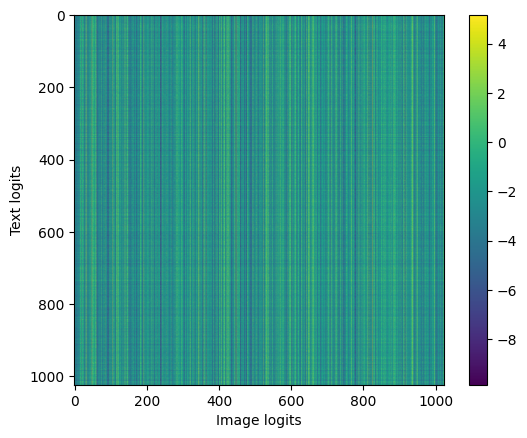

In [25]:
import matplotlib.pyplot as plt

plt.imshow(results[0].detach().cpu())
plt.xlabel("Image logits")
plt.ylabel("Text logits")
plt.colorbar()
plt.show()

In [19]:
model = MRINetwork.load_from_checkpoint(r"D:\Repos\clip-bold\models\run2\epoch=49-step=23600.ckpt")

d:\Repos\clip-bold\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [20]:
results2 = model(sample[0].cuda(), sample[1])

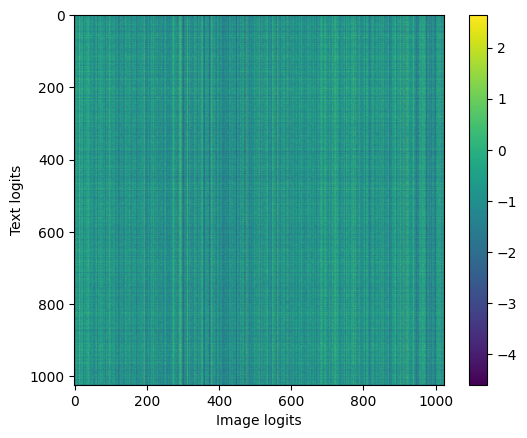

In [22]:
import matplotlib.pyplot as plt

plt.imshow(results2[0].detach().cpu())
plt.xlabel("Image logits")
plt.ylabel("Text logits")
plt.colorbar()
plt.show()

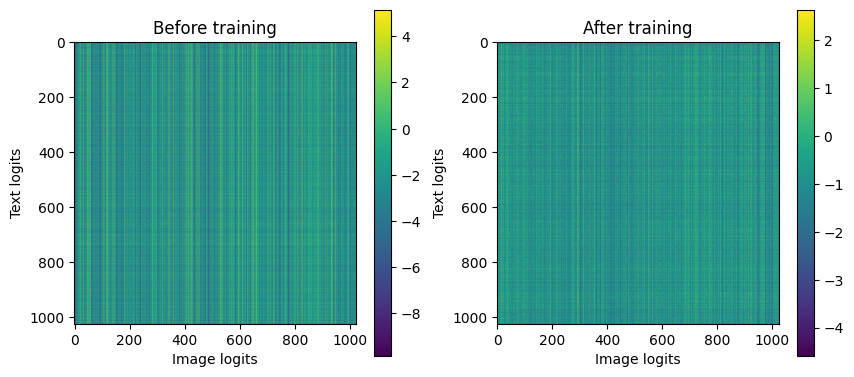

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))

im = axes[0].imshow(results[0].detach().cpu())
axes[0].set_xlabel("Image logits")
axes[0].set_ylabel("Text logits")
axes[0].set_title("Before training")
fig.colorbar(im, ax=axes[0])

im = axes[1].imshow(results2[0].detach().cpu())
axes[1].set_xlabel("Image logits")
axes[1].set_ylabel("Text logits")
axes[1].set_title("After training")

fig.colorbar(im, ax=axes[1])
plt.show()

In [49]:
import pandas as pd

df_0 = pd.read_csv(r"D:\Repos\clip-bold\models\run0\lightning_logs\version_0\metrics.csv")
df_1 = pd.read_csv(r"D:\Repos\clip-bold\models\run2\lightning_logs\version_0\metrics.csv")
df_1["epoch"] = df_1["epoch"] + 20
df_1["step"] = df_1["step"] + 10000

In [59]:
df = pd.concat([df_0, df_1])

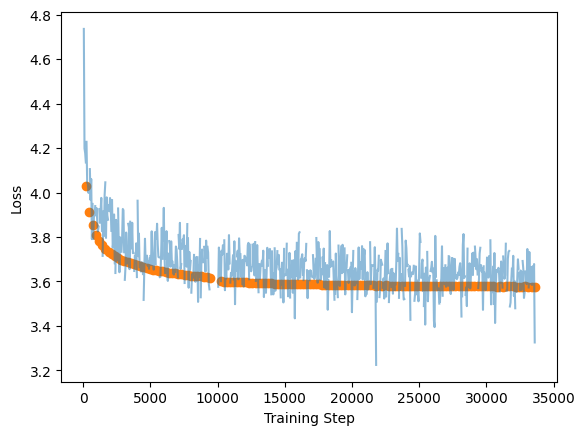

: 

In [ ]:
plt.plot(df["step"], df["train_loss"], c="C0", alpha=0.5, label="Train Loss")
plt.scatter(df["step"], df["val_loss"], c="C1", label="Validation Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.show()